# Trade full matrix

This notebook was used in colab to load trade matrix and keep only numeric codes (it was too large 7GB).

- Read the file as chunks, select coded columns.
- Drop not informative values.
- Save the result as csv.

In [66]:
#!pip install ydata-profiling

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from ydata_profiling import ProfileReport

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
import zipfile
import io

# Read the whole trading matrix and save only import data in quantities

In [ ]:
"""import zipfile
import pandas as pd

# Specify the path to your zip file
zip_file_path = "/content/drive/MyDrive/NUCLIO_drive/TFM_drive/data/FAOSTAT/all_raw/Trade_DetailedTradeMatrix_E_All_Data_(Normalized).zip"
csv_file_name = "Trade_DetailedTradeMatrix_E_All_Data_(Normalized).csv"

# Initialize an empty dataframe to store the results
filtered_data = pd.DataFrame()

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as myzip:
    # Directly read the CSV file using ZipFile.open
    with myzip.open(csv_file_name, 'r') as file:
        # Iterate over chunks of the file
        chunk_size = 100000  # Adjust the chunk size as needed
        for chunk in pd.read_csv(file, encoding="ISO-8859-1", chunksize=chunk_size):
            # Filter and drop columns
            chunk = chunk[chunk['Unit'] != '1000 USD']
            #chunk = chunk[chunk['Element'] == 'Import Quantity']
            cols_todrop = ['Reporter Country Code (M49)', 'Partner Country Code (M49)', 'Year Code',
                           'Element', 'Reporter Countries', 'Partner Countries', 'Item Code (CPC)', 'Item']
            chunk.drop(columns=cols_todrop, inplace=True)

            # Append the processed chunk to the filtered_data dataframe
            filtered_data = pd.concat([filtered_data, chunk], ignore_index=True)

# Save the filtered data to a new CSV file
filtered_data.to_csv('/content/drive/MyDrive/NUCLIO_drive/TFM_drive/data/FAOSTAT/trade_matrix_codes_only.csv', index=False) """


In [72]:
df = pd.read_csv('/content/drive/MyDrive/NUCLIO_drive/TFM_drive/data/FAOSTAT/clean_data/food_trading/trade_matrix_codes_only.csv')

In [73]:
df.head() # Had to keep only codes cause matrix is too large

,Reporter Country Code,Partner Country Code,Item Code,Element Code,Year,Unit,Value,Flag
0,2,4,230,5910,2016,t,3.00,X
1,3,3,828,5610,2004,t,12.00,A
2,4,2,231,5610,2005,t,3.00,A
3,3,3,56,5610,2005,t,52.00,A
4,7,2,176,5610,2022,t,25.06,A


In [74]:
df['Element Code'].value_counts(normalize=True) # We keep only 5610 and 5910 for now. Means Export and import quantity.

Element Code
5610    0.499212
5910    0.489029
5908    0.004016
5608    0.003740
5909    0.002064
5609    0.001713
5607    0.000120
5907    0.000105
Name: proportion, dtype: float64

In [75]:
df['import_export'] = np.where(df['Element Code'] == 5610, 'I', pd.NA)

In [76]:
df['import_export'] = np.where(df['Element Code'] == 5910, 'E', df['import_export'])

In [77]:
df['import_export'].value_counts(normalize=True, dropna=False)

import_export
I       0.499212
E       0.489029
<NA>    0.011759
Name: proportion, dtype: float64

In [78]:
df.drop(columns=['Element Code'], inplace=True)
df.dropna(subset=['import_export'], inplace=True)

In [79]:
df['Unit'].value_counts(normalize=True) # We keep only Unit in tonnes (automatic when I filtered for import/export quantity). It includes meat. An and 1000An is used for whole animals but the amount of information is negligible.

Unit
t    1.0
Name: proportion, dtype: float64

In [80]:
df['Flag'].value_counts(normalize=True) # We keep only "A" flag. Means "Official Value"

Flag
A    0.964050
X    0.023489
E    0.006569
I    0.005891
Name: proportion, dtype: float64

In [81]:
df = df[df['Flag'] == 'A']

<Axes: >

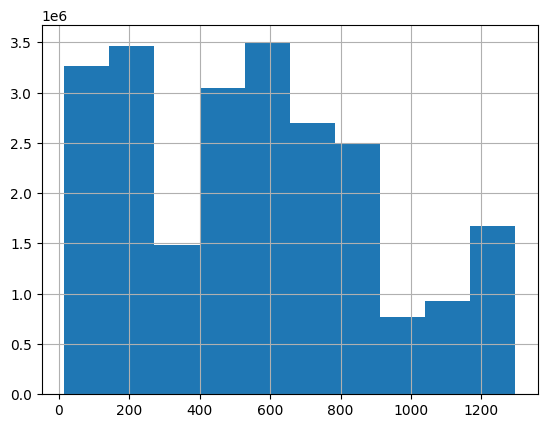

In [82]:
df['Item Code'].hist()

<Axes: >

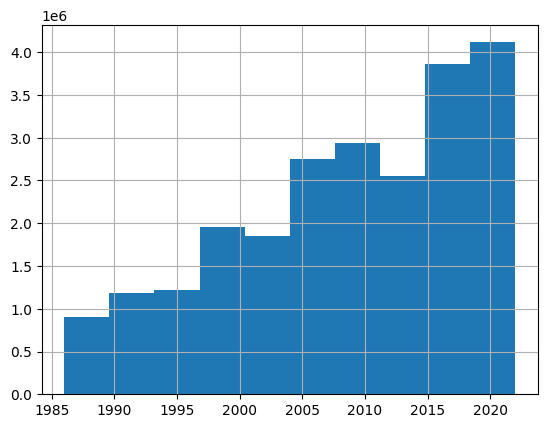

In [83]:
df['Year'].hist()

In [84]:
df.head()

,Reporter Country Code,Partner Country Code,Item Code,Year,Unit,Value,Flag,import_export
1,3,3,828,2004,t,12.00,A,I
2,4,2,231,2005,t,3.00,A,I
3,3,3,56,2005,t,52.00,A,I
4,7,2,176,2022,t,25.06,A,I
5,4,2,711,1996,t,171.00,A,I


In [85]:
df[df['Reporter Country Code'] == df['Partner Country Code']]['import_export'].value_counts(normalize=True) #More data on AUTO-imports (internal transport)

import_export
I    0.666238
E    0.333762
Name: proportion, dtype: float64

In [86]:
items = [236, 15, 564] # Soja, Trigo, Vino

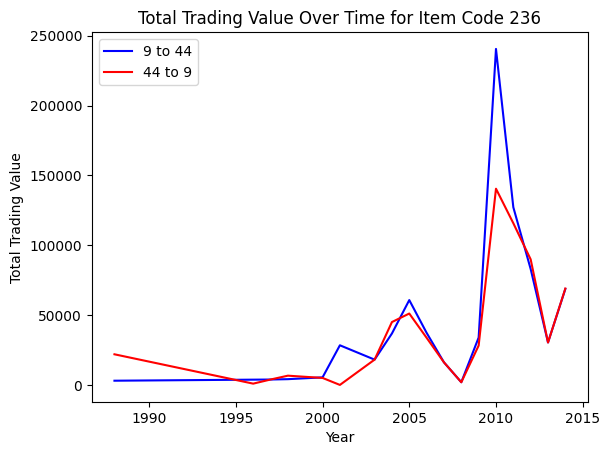

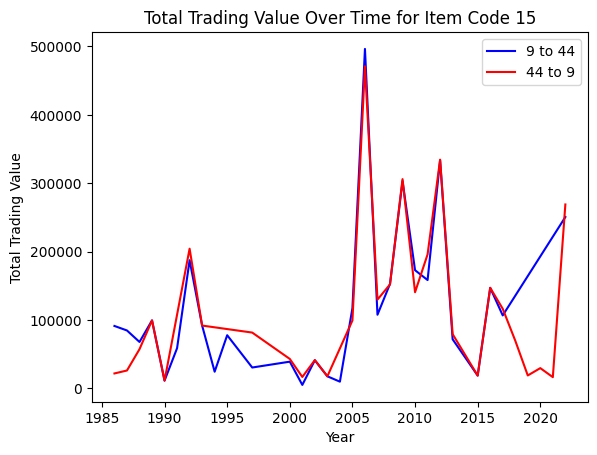

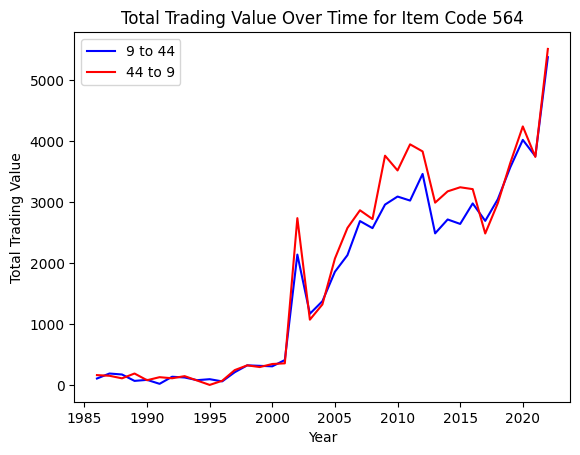

In [87]:
for item in items:
  # Specify the item code and country pair you want to analyze
  item_code_to_analyze = item
  country_pair_A = (9, 44) #Export Argentina to Colombia
  country_pair_B = (44, 9) #Import Colombia to Argentina

  # Filter the data for the specific item
  item_data = df[df['Item Code'] == item_code_to_analyze]

  # Separate data for the specific country pairs
  data_A_to_B = item_data[(item_data['Reporter Country Code'] == country_pair_A[0]) &
                          (item_data['Partner Country Code'] == country_pair_A[1]) & (item_data['import_export'] == 'E')]
  data_B_to_A = item_data[(item_data['Reporter Country Code'] == country_pair_B[0]) &
                          (item_data['Partner Country Code'] == country_pair_B[1]) & (item_data['import_export'] == 'I')]

  # Group by year and sum the values
  grouped_A_to_B = data_A_to_B.groupby('Year')['Value'].sum().reset_index()
  grouped_B_to_A = data_B_to_A.groupby('Year')['Value'].sum().reset_index()

  # Plotting the data
  plt.plot(grouped_A_to_B['Year'], grouped_A_to_B['Value'], label=f'{country_pair_A[0]} to {country_pair_A[1]}', color='blue')
  plt.plot(grouped_B_to_A['Year'], grouped_B_to_A['Value'], label=f'{country_pair_B[0]} to {country_pair_B[1]}', color='red')

  plt.xlabel('Year')
  plt.ylabel('Total Trading Value')
  plt.title(f'Total Trading Value Over Time for Item Code {item_code_to_analyze}')
  plt.legend()
  plt.show()

**Import and export information seems to be more or less the same**

We keep only import data

In [7]:
df = df[df['import_export'] == 'I']

In [9]:
df.to_csv(r'..\data\FAOSTAT\clean_data\food_trading\trade_matrix__imports_clean_codesOnly.csv', index=False)